In [1]:
import sqlalchemy
from sqlalchemy import create_engine, func, inspect

from config import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf

In [2]:
# Create engine to PostgreSQL database
engine = create_engine(config)

In [3]:
# Create inspector to get table names of database
inspector = inspect(engine)
inspector.get_table_names()

['stroke']

In [4]:
# Grab fuel table from PostgreSQL and convert to pandas DataFrame
table_name = 'stroke'
columns = inspector.get_columns(table_name)
column_names = [column['name'] for column in columns]

In [5]:
sql_query = f"SELECT * FROM {table_name}"

## Logistic Regression Model

In [71]:
# Display data table for preview
stroke_df = pd.read_sql_query(sql_query, engine)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [72]:
# Check number of stroke = 0
check = stroke_df[(stroke_df["stroke"] == 0)]
check

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
180,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
181,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
182,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
183,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
184,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3420,68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
3421,45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
3422,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
3423,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [73]:
# Check number of stroke = 1
check = stroke_df[(stroke_df["stroke"] == 1)]
check

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
175,10548,Male,66.0,0,0,Yes,Private,Rural,76.46,21.2,formerly smoked,1
176,52282,Male,57.0,0,0,Yes,Private,Rural,197.28,34.5,formerly smoked,1
177,45535,Male,68.0,0,0,Yes,Private,Rural,233.94,42.4,never smoked,1
178,40460,Female,68.0,1,1,Yes,Private,Urban,247.51,40.5,formerly smoked,1


In [74]:
# Drop ID column
stroke_df = stroke_df.drop(columns="id")
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [75]:
# Get dummy columns
stroke_dummies = pd.get_dummies(stroke_df, dtype=int)
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [76]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [77]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [78]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [79]:
# Create a Logistic Regression model
classifier = LogisticRegression(solver="lbfgs", random_state=1)

In [80]:
# Fit the model to training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [81]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [82]:
# Generate a confusion matrix for the model
test_matrix = confusion_matrix(y_test, predictions)
print(test_matrix)

[[811   1]
 [ 45   0]]


In [83]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.00      0.00      0.00        45

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.90      0.95      0.92       857



In [84]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.9463243873978997

## Logistic Regression Model Optimization
- try balancing class weights

In [85]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced", penalty='l2')

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [86]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [87]:
# Generate a confusion matrix for the model
test_matrix = confusion_matrix(y_test, predictions)
print(test_matrix)

[[590 222]
 [ 13  32]]


In [88]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       812
           1       0.13      0.71      0.21        45

    accuracy                           0.73       857
   macro avg       0.55      0.72      0.52       857
weighted avg       0.93      0.73      0.80       857



In [89]:
# Get accuracy score
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7257876312718786

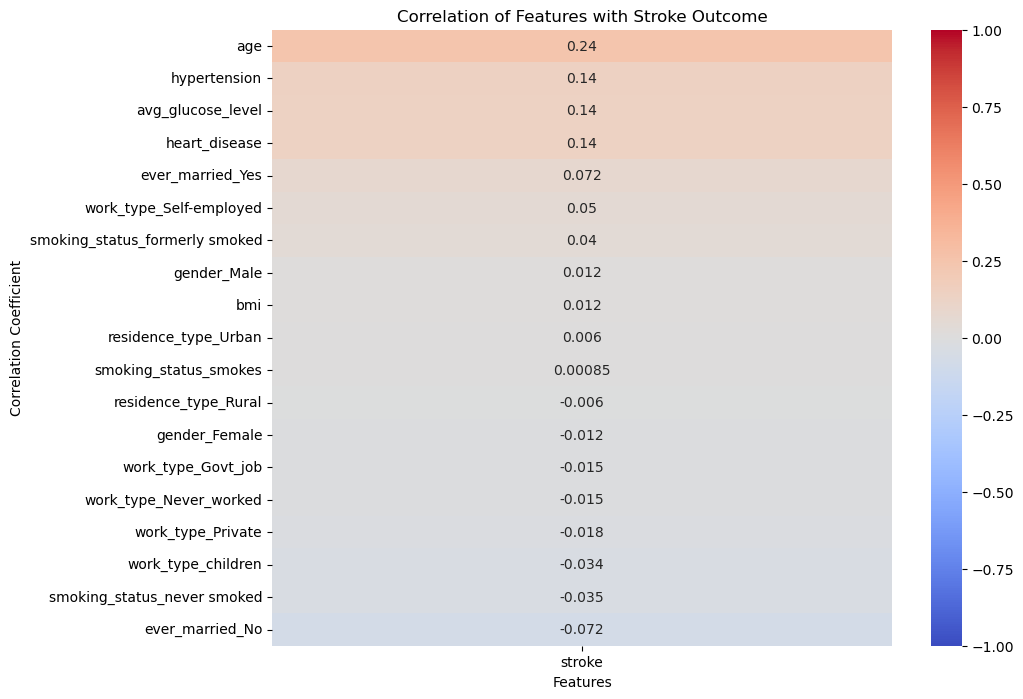

In [90]:
# Calculate the correlation matrix
correlation_matrix = stroke_dummies.corr()

# Extract the correlation of the outcome variable 'stroke' with other features
correlation_with_outcome = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_outcome.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation of Features with Stroke Outcome')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')

plt.show()

## Logistic Regression Model Optimization
- feature importances

In [91]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [92]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [93]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [94]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [95]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced")

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [96]:
# Get feature importances (coefficients)
feature_importances = classifier.coef_[0]

In [97]:
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [98]:
# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

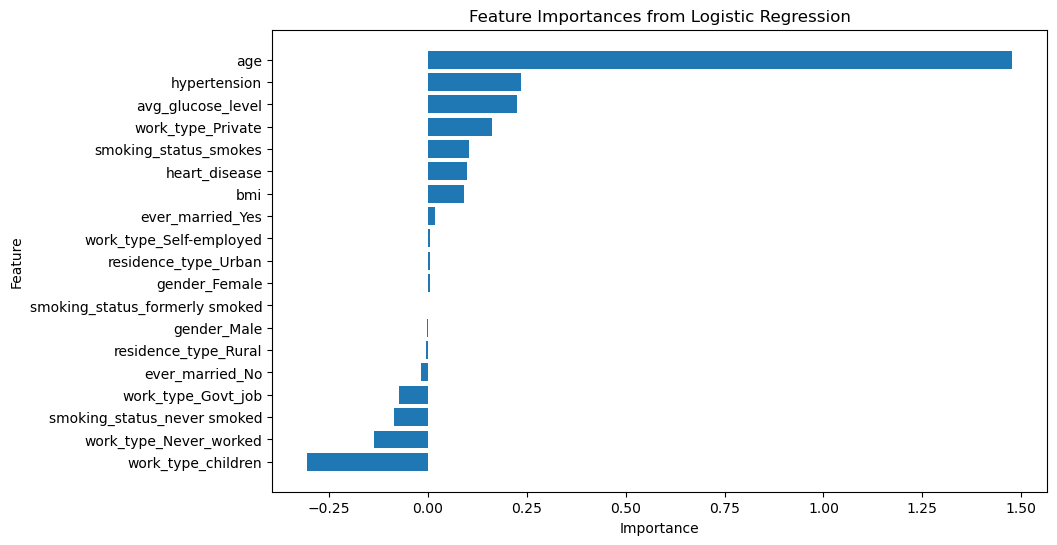

In [99]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## Logistic Regression Model Optimization
- removed `gender` and `residence` type column

In [100]:
# Drop gender and residence_type column
stroke_df_noGenderResidence = stroke_df.drop(columns=["gender", "residence_type"])
stroke_df_noGenderResidence.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
1,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
2,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
3,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1
4,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked,1


In [101]:
stroke_dummies_noGenderResidence = pd.get_dummies(stroke_df_noGenderResidence, dtype=int)
stroke_dummies_noGenderResidence.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,1,0,0,1,0,0,0,0,1
3,79.0,1,0,174.12,24.0,1,0,1,0,0,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,1,0,0,1,0,0


In [102]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_noGenderResidence["stroke"]
X = stroke_dummies_noGenderResidence.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,0,1,0,0,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,0,1,0,0,1,0,0,0,0,1
3,79.0,1,0,174.12,24.0,0,1,0,0,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,0,1,0,0,1,0,0


In [103]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [104]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [105]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced")

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [106]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [107]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       812
           1       0.13      0.71      0.21        45

    accuracy                           0.73       857
   macro avg       0.55      0.72      0.52       857
weighted avg       0.93      0.73      0.80       857



In [108]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7269544924154026

## Logistic Regression Model Optimization
- removed `marriage` column

In [109]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [110]:
# Drop ID column and ever_married column
stroke_df_noMarriage = stroke_df.drop(columns="ever_married")
stroke_df_noMarriage.head()

,gender,age,hypertension,heart_disease,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Private,Urban,186.21,29.0,formerly smoked,1


In [111]:
stroke_dummies_noMarriage = pd.get_dummies(stroke_df_noMarriage, dtype=int)
stroke_dummies_noMarriage.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [112]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_noMarriage["stroke"]
X = stroke_dummies_noMarriage .drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,0,1,0,0,0,1,1,0,0


In [113]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [114]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [115]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced")

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [116]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [117]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       812
           1       0.13      0.71      0.21        45

    accuracy                           0.72       857
   macro avg       0.55      0.72      0.52       857
weighted avg       0.93      0.72      0.80       857



In [118]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7246207701283547

## Logistic Regression Model Optimization
- using solver=saga, penalty="elasticnet", l1_ratio=0.5

In [119]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [120]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [121]:
# Create the Logistic Regression model
classifier = LogisticRegression(solver="saga", penalty="elasticnet",  l1_ratio=0.5)

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [122]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.00      0.00      0.00        45

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.90      0.95      0.92       857



In [123]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.9463243873978997

## Logistic Regression Model Optimization
- removed `never_worked` and `children` from work_type column

In [124]:
stroke_df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [125]:
stroke_df_noChildren = stroke_df[(stroke_df['work_type'] != 'Never_worked') & (stroke_df['work_type'] != 'children')]
stroke_df_noChildren.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [126]:
stroke_dummies_noChildren = pd.get_dummies(stroke_df_noChildren, dtype=int)
stroke_dummies_noChildren.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,1,1,0,0


In [127]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_noChildren["stroke"]
X = stroke_dummies_noChildren.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,1,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,1,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,1,0,0,1,1,0,0


In [128]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [129]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [130]:
# Create the Logistic Regression model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced")

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [131]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [132]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       791
           1       0.15      0.87      0.25        45

    accuracy                           0.72       836
   macro avg       0.57      0.79      0.54       836
weighted avg       0.94      0.72      0.80       836



In [133]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7248803827751196

## Logistic Regression Model Optimization
- using solver=saga, penalty="elasticnet", l1_ratio=0.5 -removed `never_worked` and `children` from work_type column

In [134]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_noChildren["stroke"]
X = stroke_dummies_noChildren.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,1,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,1,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,1,0,0,1,1,0,0


In [135]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [136]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [137]:
# Create the Logistic Regression model
classifier = LogisticRegression(solver="saga", penalty="elasticnet",  l1_ratio=0.5)

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [138]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [139]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       791
           1       1.00      0.02      0.04        45

    accuracy                           0.95       836
   macro avg       0.97      0.51      0.51       836
weighted avg       0.95      0.95      0.92       836



In [140]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.9473684210526315

## Logistic Regression Model Optimization
- `avg_glucose_level`, `bmi`, and `age` columns only

In [141]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [142]:
stroke_df_topThree = stroke_df[["avg_glucose_level", "bmi", "age", "stroke"]]
stroke_df_topThree.head()

,avg_glucose_level,bmi,age,stroke
0,228.69,36.6,67.0,1
1,105.92,32.5,80.0,1
2,171.23,34.4,49.0,1
3,174.12,24.0,79.0,1
4,186.21,29.0,81.0,1


In [143]:
stroke_dummies_topThree = pd.get_dummies(stroke_df_topThree, dtype=int)
stroke_dummies_topThree.head()

,avg_glucose_level,bmi,age,stroke
0,228.69,36.6,67.0,1
1,105.92,32.5,80.0,1
2,171.23,34.4,49.0,1
3,174.12,24.0,79.0,1
4,186.21,29.0,81.0,1


In [144]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_topThree["stroke"]
X = stroke_dummies_topThree.drop(columns="stroke")

X.head()

,avg_glucose_level,bmi,age
0,228.69,36.6,67.0
1,105.92,32.5,80.0
2,171.23,34.4,49.0
3,174.12,24.0,79.0
4,186.21,29.0,81.0


In [145]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [146]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [147]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="lbfgs", random_state=1, class_weight = "balanced")

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [148]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [149]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       812
           1       0.13      0.76      0.22        45

    accuracy                           0.71       857
   macro avg       0.55      0.73      0.52       857
weighted avg       0.94      0.71      0.79       857



In [150]:
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7129521586931156

## Logistic Regression Model Optimization
- using solver=saga, penalty="elasticnet", l1_ratio=0.5

- `avg_glucose_level`, `bmi`, and `age` columns only

In [151]:
stroke_dummies_topThree = pd.get_dummies(stroke_df_topThree, dtype=int)
stroke_dummies_topThree.head()

,avg_glucose_level,bmi,age,stroke
0,228.69,36.6,67.0,1
1,105.92,32.5,80.0,1
2,171.23,34.4,49.0,1
3,174.12,24.0,79.0,1
4,186.21,29.0,81.0,1


In [152]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies_topThree["stroke"]
X = stroke_dummies_topThree.drop(columns="stroke")

X.head()

,avg_glucose_level,bmi,age
0,228.69,36.6,67.0
1,105.92,32.5,80.0
2,171.23,34.4,49.0
3,174.12,24.0,79.0
4,186.21,29.0,81.0


In [153]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [154]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [155]:
# Create the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver="saga", penalty="elasticnet",  l1_ratio=0.5)

# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [156]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [157]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print(test_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.00      0.00      0.00        45

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.90      0.95      0.92       857



C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression Model Optimization
- Feature engineering : Adding Polynomial features

In [158]:
# Display data table for preview
stroke_df_opt1 = pd.read_sql_query(sql_query, engine)
stroke_df_opt1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [159]:
# Drop ID column
stroke_df_opt1 = stroke_df_opt1.drop(columns="id")
stroke_df_opt1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [160]:
stroke_dummies = pd.get_dummies(stroke_df_opt1, dtype=int)
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [161]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [162]:
# Feature Engineering: Adding Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

In [163]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [164]:
# Create a StandardScaler instances
scaler = StandardScaler()

In [165]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [166]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(LogisticRegression(random_state=1), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [167]:
# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'C': 0.1, 'class_weight': None, 'solver': 'lbfgs'}


In [168]:
# Create the Logistic Regression model with best parameters
classifier = LogisticRegression(**best_params, random_state=1)

In [169]:
# Fit the model using training data
stroke_model = classifier.fit(X_train_scaled, y_train)

In [170]:
# Make a prediction using the testing data
predictions = stroke_model.predict(X_test_scaled)

In [171]:
# Generate a confusion matrix for the model
test_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(test_matrix)

Confusion Matrix:
[[811   1]
 [ 45   0]]


In [172]:
# Print the classification report for the model
test_report = classification_report(y_test, predictions)
print("Classification Report:")
print(test_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.00      0.00      0.00        45

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.90      0.95      0.92       857



In [173]:
# Print accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {acc_score}")

Accuracy Score: 0.9463243873978997


In [174]:
# Cross-validation score
cv_scores = cross_val_score(classifier, X_poly, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")

C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Cross-Validation Scores: [0.94890511 0.94306569 0.94452555 0.94890511 0.9459854 ]
Mean Cross-Validation Score: 0.9462773722627738


C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## K Nearest Neighbors

In [175]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=3)

In [176]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train) 

KNeighborsClassifier(n_neighbors=3)

In [177]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

In [178]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       812
           1       0.20      0.04      0.07        45

    accuracy                           0.94       857
   macro avg       0.57      0.52      0.52       857
weighted avg       0.91      0.94      0.92       857



In [179]:
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.94049008168028

## Random Forest Model

In [180]:
# Get original dataframe
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [181]:
# Look at the dummy dataframe
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [182]:
# Split preprocessed data into features 
X = stroke_dummies.copy()
X.drop(columns="stroke", axis=1, inplace = True)
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [183]:
# Split preprocessed data into target array 
y = stroke_df["stroke"].ravel()
y[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [184]:
 # Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [185]:
# Create StandardScaler and fit the scaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [186]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [187]:
# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=500)

In [188]:
# Fit the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [189]:
# Predict on the model
predictions = rf_model.predict(X_test_scaled)

In [190]:
# Create a confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [192]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,810,0
Actual 1,47,0


Accuracy Score : 0.9451575262543758
Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       810
           1       0.00      0.00      0.00        47

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.89      0.95      0.92       857



C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Optimization

In [193]:
# Look at important features to see which ones can be deleted

importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.26106733423835826, 'avg_glucose_level'),
 (0.24570155695283571, 'age'),
 (0.2213828434162999, 'bmi'),
 (0.031375233302054155, 'hypertension'),
 (0.030306145428415275, 'heart_disease'),
 (0.021296771645670058, 'residence_type_Rural'),
 (0.021055748392143844, 'residence_type_Urban'),
 (0.02088559575415084, 'work_type_Private'),
 (0.020596974227496432, 'smoking_status_formerly smoked'),
 (0.020042481849057464, 'smoking_status_never smoked'),
 (0.01909713064977673, 'gender_Male'),
 (0.018870527543107977, 'gender_Female'),
 (0.018859731028162026, 'work_type_Self-employed'),
 (0.016539004140759025, 'smoking_status_smokes'),
 (0.012155772717861592, 'work_type_Govt_job'),
 (0.010349975421834676, 'ever_married_Yes'),
 (0.010303408618117973, 'ever_married_No'),
 (0.00010538122523599373, 'work_type_children'),
 (8.383448662125013e-06, 'work_type_Never_worked')]

<Axes: title={'center': 'Features Importances'}, ylabel='Features'>

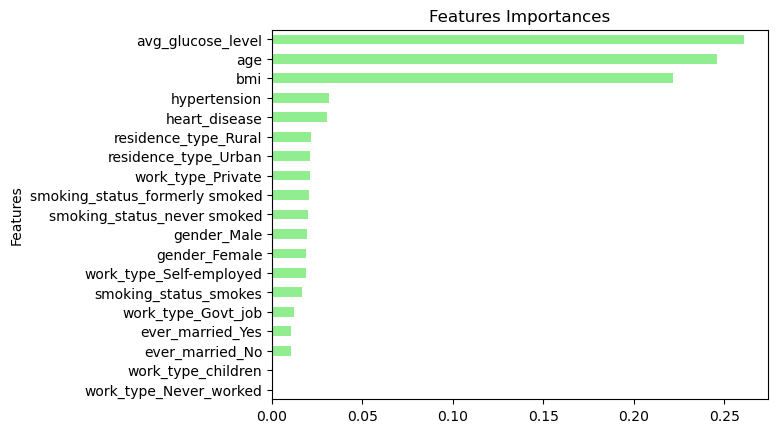

In [195]:
# Graph out the importances

importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, ylabel="Features")

In [210]:
# Look at stroke dataframe
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [211]:
# Optimize the model by dropping unwanted columns
selected_df = stroke_df.copy()
selected_df = selected_df.drop(columns=["work_type", "residence_type", "ever_married"])
selected_df.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,105.92,32.5,never smoked,1
2,Female,49.0,0,0,171.23,34.4,smokes,1
3,Female,79.0,1,0,174.12,24.0,never smoked,1
4,Male,81.0,0,0,186.21,29.0,formerly smoked,1


In [212]:
# Create dummy columns for selected features
selected_dummies = pd.get_dummies(selected_df, dtype=int)
selected_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,1,0,0


In [213]:
# Split the data into selected features
X = selected_dummies.copy()
X.drop(columns="stroke", axis=1, inplace = True)
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,1,0,0


In [214]:
# Split the data into target array
y = selected_dummies["stroke"].ravel()
y[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [215]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [216]:
# Create StandardScaler and fit the scaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [217]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [218]:
# Create an optimized model for RandomForest
optimize_model = RandomForestClassifier(n_estimators=600)

In [219]:
# Fit the model
optimize_model = optimize_model.fit(X_train_scaled, y_train)

In [220]:
# Make predictions on the model
predictions = optimize_model.predict(X_test_scaled)

In [221]:
# Create a confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [222]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,798,1
Actual 1,58,0


Accuracy Score : 0.9311551925320887
Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       799
           1       0.00      0.00      0.00        58

    accuracy                           0.93       857
   macro avg       0.47      0.50      0.48       857
weighted avg       0.87      0.93      0.90       857



## Random Forest Optimization
- use features `bmi`, `age`, and `avg_glucose_level` only
- Top 3 features

In [223]:
# Look at stroke dataframe
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [224]:
# Optimize the model by dropping unwanted columns
topthree_df = stroke_df.copy()
topthree_df = topthree_df.drop(columns=["work_type", "residence_type", "ever_married", "gender", "hypertension", 
                                        "heart_disease", "smoking_status"])
topthree_df.head()

,age,avg_glucose_level,bmi,stroke
0,67.0,228.69,36.6,1
1,80.0,105.92,32.5,1
2,49.0,171.23,34.4,1
3,79.0,174.12,24.0,1
4,81.0,186.21,29.0,1


In [225]:
# Split the data into selected features
X = topthree_df.copy()
X.drop(columns="stroke", axis=1, inplace = True)
X.head()

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,80.0,105.92,32.5
2,49.0,171.23,34.4
3,79.0,174.12,24.0
4,81.0,186.21,29.0


In [226]:
# Split the data into target array
y = topthree_df["stroke"].ravel()
y[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [227]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [228]:
# Create StandardScaler and fit the scaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [229]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [230]:
# Create an optimized model for RandomForest
three_model = RandomForestClassifier(n_estimators=600)

In [231]:
# Fit the model
three_model = three_model.fit(X_train_scaled, y_train)

In [232]:
# Make predictions on the model
predictions = three_model.predict(X_test_scaled)

In [233]:
# Create a confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [234]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,806,5
Actual 1,45,1


Accuracy Score : 0.941656942823804
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       811
           1       0.17      0.02      0.04        46

    accuracy                           0.94       857
   macro avg       0.56      0.51      0.50       857
weighted avg       0.91      0.94      0.92       857



## Decision Tree

In [10]:
# Select dataframe
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [11]:
# Create new dataframe
dt_df = stroke_df.copy()
dt_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [12]:
# Drop unwanted columns
new_df = dt_df.drop(columns=["work_type", "residence_type", "ever_married"])
new_df.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,105.92,32.5,never smoked,1
2,Female,49.0,0,0,171.23,34.4,smokes,1
3,Female,79.0,1,0,174.12,24.0,never smoked,1
4,Male,81.0,0,0,186.21,29.0,formerly smoked,1


In [13]:
# Create dummy columns
dt_dummies = pd.get_dummies(new_df, dtype=int)
dt_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,1,0,0


In [14]:
# Select features
X_dt = dt_dummies.copy()
X_dt.drop(columns="stroke", axis=1, inplace = True)
X_dt.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,1,0,0


In [15]:
# Select target array
y_dt = dt_dummies["stroke"].ravel()
y_dt[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [16]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt)

In [17]:
# Create StandardScaler
scaler = StandardScaler()

In [18]:
# Fit the scaler
X_scaler = scaler.fit(X_train)

In [19]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Create a Decision Tree model
dt_model = DecisionTreeClassifier()

In [22]:
# Fit the model
dt_model = dt_model.fit(X_train_scaled, y_train)

In [23]:
# Predict on the model
predictions = dt_model.predict(X_test_scaled)

In [24]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [25]:
# Print confusion matrix
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,759,54
Actual 1,39,5


Accuracy Score : 0.8914819136522754
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       813
           1       0.08      0.11      0.10        44

    accuracy                           0.89       857
   macro avg       0.52      0.52      0.52       857
weighted avg       0.91      0.89      0.90       857



## Decision Tree Optimization
- use top three importances

In [26]:
# See feature importances
importances = dt_model.feature_importances_
importances

array([0.21734213, 0.01968193, 0.04244225, 0.31432388, 0.30156655,
       0.00388206, 0.01326371, 0.02381755, 0.03282794, 0.03085199])

In [27]:
# Select only top 3 importances
threshold = 0.1
selected_features = X_dt.columns[importances > threshold]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [28]:
# See the top three importances
X_train_selected

,age,avg_glucose_level,bmi
388,67.0,144.10,27.6
2836,12.0,108.63,23.4
2975,18.0,100.47,31.9
1253,64.0,187.87,32.3
523,56.0,70.02,32.3
...,...,...,...
2600,52.0,93.28,36.3
1260,68.0,93.61,24.9
2860,33.0,77.94,28.7
2702,37.0,156.69,35.2


In [29]:
# Fit the scaler
X_train_selected_scaler = scaler.fit(X_train_selected)

In [30]:
# Scale the data
X_train_selected_scaled = X_train_selected_scaler.transform(X_train_selected)
X_test_selected_scaled = X_train_selected_scaler.transform(X_test_selected)

In [31]:
# Create a Decision Tree model
dt_selected = DecisionTreeClassifier(max_depth=3,
                                         )

In [32]:
# Fit the model
dt_selected.fit(X_train_selected_scaled, y_train)

DecisionTreeClassifier(max_depth=3)

In [33]:
# Predict on the model
prediction_selected = dt_selected.predict(X_test_selected_scaled)

In [34]:
# Create a confusion matrix
cm_selected = confusion_matrix(y_test, prediction_selected)
cm_selected = pd.DataFrame(
    cm_selected, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [35]:
# Show the accuracy
accuracy_selected = accuracy_score(prediction_selected, y_test)
accuracy_selected

0.9463243873978997

In [36]:
print("Confusion Matrix")
display(cm_selected)
print(f"Accuracy Score : {accuracy_selected}")
print("Classification Report")
print(classification_report(y_test, prediction_selected))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,811,2
Actual 1,44,0


Accuracy Score : 0.9463243873978997
Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       813
           1       0.00      0.00      0.00        44

    accuracy                           0.95       857
   macro avg       0.47      0.50      0.49       857
weighted avg       0.90      0.95      0.92       857



## Decision Tree Optimization
- Hyperparameters and gini criterion

In [44]:
# Read in csv
data = pd.read_csv('Resources/cleaned_data.csv')

In [45]:
# Check info and dtypes
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3425 non-null   int64  
 1   gender             3425 non-null   object 
 2   age                3425 non-null   float64
 3   hypertension       3425 non-null   int64  
 4   heart_disease      3425 non-null   int64  
 5   ever_married       3425 non-null   object 
 6   work_type          3425 non-null   object 
 7   Residence_type     3425 non-null   object 
 8   avg_glucose_level  3425 non-null   float64
 9   bmi                3425 non-null   float64
 10  smoking_status     3425 non-null   object 
 11  stroke             3425 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 321.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000
mean,37333.512117,48.652555,0.119124,0.060146,108.311670,30.292350,0.052555
std,21050.593185,18.850018,0.323982,0.237792,47.706754,7.295778,0.223175
min,84.000000,10.000000,0.000000,0.000000,55.120000,11.500000,0.000000
25%,18986.000000,34.000000,0.000000,0.000000,77.230000,25.300000,0.000000
50%,38067.000000,50.000000,0.000000,0.000000,92.350000,29.100000,0.000000
75%,55459.000000,63.000000,0.000000,0.000000,116.200000,34.100000,0.000000
max,72915.000000,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [46]:
# Drop null values and get dummy columns
data = data.dropna() 
data = pd.get_dummies(data, drop_first=True)

In [47]:
X = data.drop('stroke', axis=1)  # Features (assuming 'stroke' is the target variable)
y = data['stroke']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Initialize the model with desired hyperparameters
clf = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [49]:
y_pred = clf.predict(X_test)

In [50]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.94
Confusion Matrix:
[[964   5]
 [ 59   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       969
           1       0.00      0.00      0.00        59

    accuracy                           0.94      1028
   macro avg       0.47      0.50      0.48      1028
weighted avg       0.89      0.94      0.91      1028



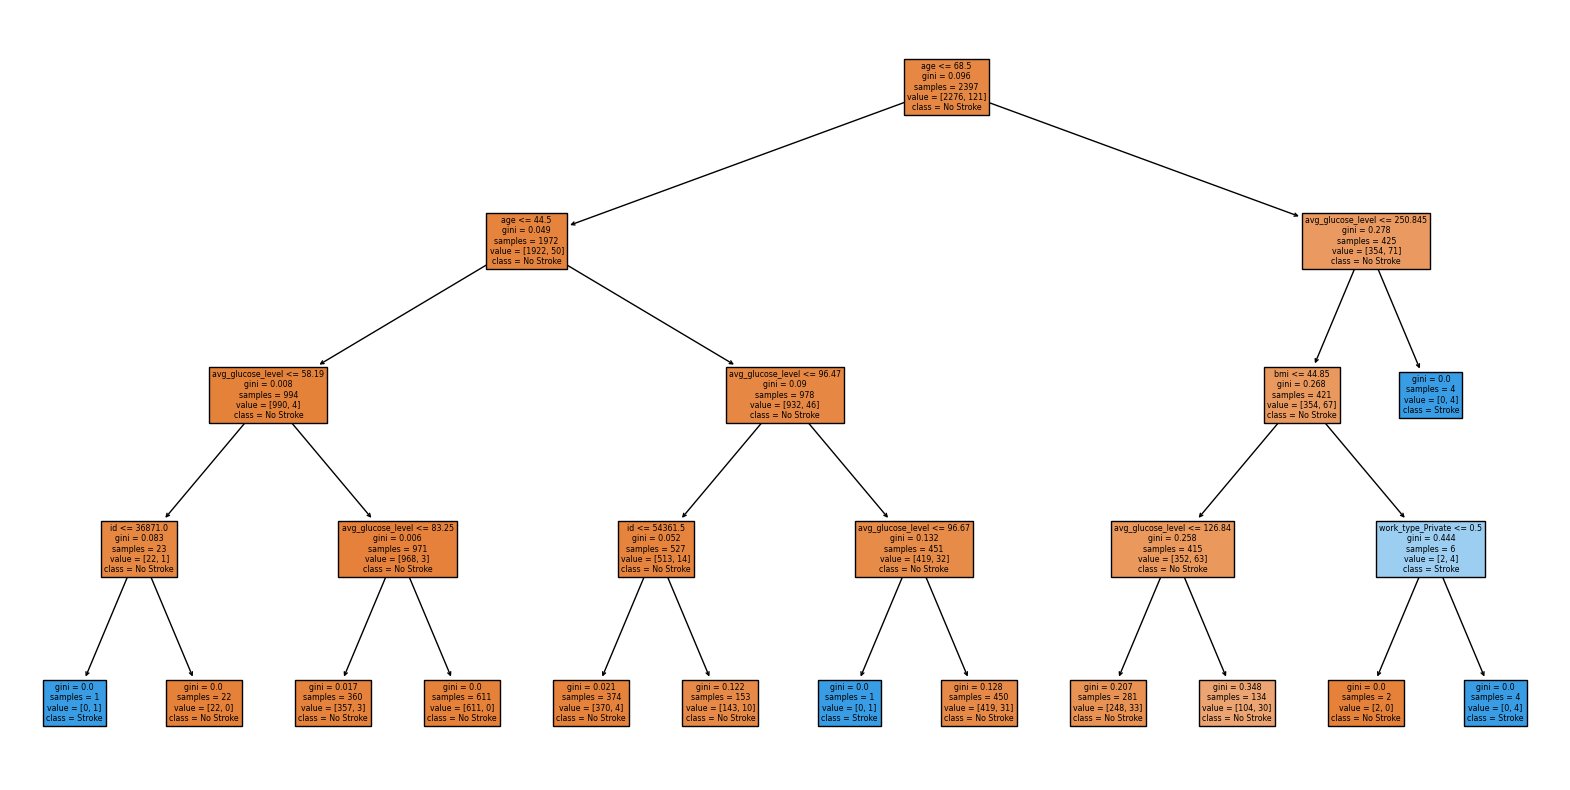

In [51]:
# Convert the Index object to a list
feature_names = X.columns.tolist()

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=['No Stroke', 'Stroke'])
plt.show()

## Deep Learning - Neural Network

In [52]:
# Display data table for preview
stroke_df_nn = pd.read_sql_query(sql_query, engine)
stroke_df_nn.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [53]:
# Drop ID column
stroke_df_nn = stroke_df_nn.drop(columns="id")
stroke_df_nn.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [54]:
stroke_dummies = pd.get_dummies(stroke_df_nn, dtype=int)
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [55]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [56]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [57]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [58]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = X_train_scaled.shape[1]

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim= num_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 80)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,061 (15.86 KB)

 Trainable params: 4,061 (15.86 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [60]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9404 - loss: 0.3184
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9378 - loss: 0.1931
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9412 - loss: 0.1750
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9539 - loss: 0.1460
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9519 - loss: 0.1515
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9435 - loss: 0.1606
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9440 - loss: 0.1570
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9540 - loss: 0.1349
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9417 - loss: 0.1572
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1319
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1411
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9706 - loss: 0.0827
Epoch 70/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0807
Epoch 71/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9708 - loss: 0.0813
Epoch 72/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - loss: 0.0700
Epoch 73/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9646 - loss: 0.0901
Epoch 74/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9665 - loss: 0.0884
Epoch 75/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.0697
Epoch 76/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9656 - loss: 0.0874
Epoch 77/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9711 - loss: 0.0742
Epoch 78/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9683 - loss: 0.0778
Epoch 79/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.0785
Epoch 80/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9

In [61]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

27/27 - 1s - 19ms/step - accuracy: 0.9277 - loss: 0.3935
Loss: 0.39346832036972046, Accuracy: 0.9276546239852905


In [279]:
# Predict the classes on the test data
y_pred_prob = nn.predict(X_test_scaled)
# Convert predicted probabilities to class labels (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [280]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[787  25]
 [ 41   4]]


In [281]:
# Generate the classification report
class_report = classification_report(y_test, y_pred_classes)

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       812
           1       0.14      0.09      0.11        45

    accuracy                           0.92       857
   macro avg       0.54      0.53      0.53       857
weighted avg       0.91      0.92      0.92       857



## Neural Network Optimization 1 
- increasing # of hidden layers

In [282]:
# Display data table for preview
stroke_df_nn_2 = pd.read_sql_query(sql_query, engine)
stroke_df_nn_2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [283]:
# Drop ID column
stroke_df_nn_2 = stroke_df_nn_2.drop(columns="id")
stroke_df_nn_2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [284]:
stroke_dummies = pd.get_dummies(stroke_df_nn_2, dtype=int)
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [285]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
X = stroke_dummies.drop(columns="stroke")

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [286]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [287]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [288]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = X_train_scaled.shape[1]

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=120, activation='relu', input_dim= num_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu'))

#Third hidden layer - optimization attempt 1
nn.add(tf.keras.layers.Dense(units=50, activation='relu'))

#Fourth hidden layer - optimization attempt 1
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 120)                 │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 80)                  │           9,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           4,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,691 (69.11 KB)

 Trainable params: 17,691 (69.11 KB)

 Non-trainable params: 0 (0.00 B)

In [289]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [290]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7222 - loss: 0.4984
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9496 - loss: 0.1678
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9481 - loss: 0.1616
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9472 - loss: 0.1631
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9511 - loss: 0.1457
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9533 - loss: 0.1407
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9544 - loss: 0.1441
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1465
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9464 - loss: 0.1429
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1421
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1257
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [62]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

27/27 - 0s - 3ms/step - accuracy: 0.9277 - loss: 0.3935
Loss: 0.39346832036972046, Accuracy: 0.9276546239852905


In [63]:
# Predict the classes on the test data
y_pred_prob = nn.predict(X_test_scaled)
# Convert predicted probabilities to class labels (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [64]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the classification report
class_report = classification_report(y_test, y_pred_classes)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[792  20]
 [ 42   3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       812
           1       0.13      0.07      0.09        45

    accuracy                           0.93       857
   macro avg       0.54      0.52      0.53       857
weighted avg       0.91      0.93      0.92       857



## Neural Network Optimization 
- Removing less important features based on random forest model

In [65]:
# Display data table for preview
stroke_df_nn_3 = pd.read_sql_query(sql_query, engine)
stroke_df_nn_3.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [66]:
# Drop ID column
stroke_df_nn_3 = stroke_df_nn_3.drop(columns="id")
stroke_df_nn_3.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [67]:
stroke_dummies = pd.get_dummies(stroke_df_nn_3, dtype=int)
stroke_dummies.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0


In [68]:
# Split our preprocessed data into our features and target arrays
y = stroke_dummies["stroke"]
# dropping "stroke", "residence_type_Rural", "work_type_Govt_job", "work_type_Never_worked",
#"work_type_Private", "work_type_Self-employed", "work_type_children", "ever_married_No", 
#"smoking_status_never_smoked"
#Optimization attempt number 2
X = stroke_dummies.drop(columns=["stroke", "residence_type_Rural", "work_type_Govt_job", "work_type_Never_worked",
                       "work_type_Private", "work_type_Self-employed", "work_type_children", "ever_married_No", 
                        "smoking_status_never smoked"])
                       

X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_Yes,residence_type_Urban,smoking_status_formerly smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,0,1,1,1,1,0
1,80.0,0,1,105.92,32.5,0,1,1,0,0,0
2,49.0,0,0,171.23,34.4,1,0,1,1,0,1
3,79.0,1,0,174.12,24.0,1,0,1,0,0,0
4,81.0,0,0,186.21,29.0,0,1,1,1,1,0


In [69]:
# Split the preprocessed data into a training and testing dataset
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [70]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [300]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = X_train_scaled.shape[1]

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=120, activation='relu', input_dim= num_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu'))

#Third hidden layer - optimization attempt 1
nn.add(tf.keras.layers.Dense(units=50, activation='relu'))

#Fourth hidden layer - optimization attempt 1
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

C:\Users\ourfa\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 120)                 │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 80)                  │           9,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │           4,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,731 (65.36 KB)

 Trainable params: 16,731 (65.36 KB)

 Non-trainable params: 0 (0.00 B)

In [301]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [302]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9001 - loss: 0.3582
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1797
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1538
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1522
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9452 - loss: 0.1525
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1626
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9488 - loss: 0.1455
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9499 - loss: 0.1326
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1376
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1314
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9477 - loss: 0.1463
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [303]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

27/27 - 0s - 8ms/step - accuracy: 0.9172 - loss: 0.9018
Loss: 0.9017947316169739, Accuracy: 0.9171528816223145


In [304]:
# Predict the classes on the test data
y_pred_prob = nn.predict(X_test_scaled)
# Convert predicted probabilities to class labels (0 or 1)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [305]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the classification report
class_report = classification_report(y_test, y_pred_classes)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[780  32]
 [ 39   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       812
           1       0.16      0.13      0.14        45

    accuracy                           0.92       857
   macro avg       0.56      0.55      0.55       857
weighted avg       0.91      0.92      0.91       857

